# Problem Statement

Ecommerce company is evaluating the customer experience. So they run a survey among the customers to understand the feedback from the customers. They see that late delivery is one most frequent problem faced by the customer. However, the consumer experience manager says that the late delivery % is similar to industry average. We should do hypothesis test to compare organization with industry average which is 0.06.

Establish the fact that organization has a poor record in delivery. Evaluate the current algorithm to estimate delivery. The current algo is simplistic. We decide to build a intelligent system which predict delivery date by taking lot of factor into account. We roll out this algorithm for 10% of customer. Compare complaint % between the two samples 

# Solution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind, ztest
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import tt_ind_solve_power
import scipy.stats as sc
from scipy.stats import binom, norm, ttest_rel
from IPython.display import Image

In [2]:
orders = pd.read_csv('ecommerce_orders.csv')

In [3]:
# Reading reviews data
reviews = pd.read_csv('ecommerce_reviews.csv')

In [4]:
# Merging the orders dataset with the reviews dataset
order_reviews = pd.merge(orders, reviews, how='left', left_on='order_id', right_on= 'order_id')

In [5]:
# Removing any missing values in the order_ids and delivery dates
order_reviews = order_reviews.dropna(subset = ['order_id', 'order_delivered_customer_date'])

In [6]:
# Sorting the value by the date
order_reviews = order_reviews.sort_values(by='order_delivered_customer_date').reset_index(drop=True)

In [7]:
# Removing duplicate values from the order_reviews dataset
order_reviews = order_reviews.drop_duplicates(subset='order_id')

In [8]:
# Dropping columns irrelevant to the problem statement
order_reviews = order_reviews.drop(columns = ['customer_id', 'order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date'])

### 1. Establish the fact that organization has a poor record in delivery. 

(-10, 60)

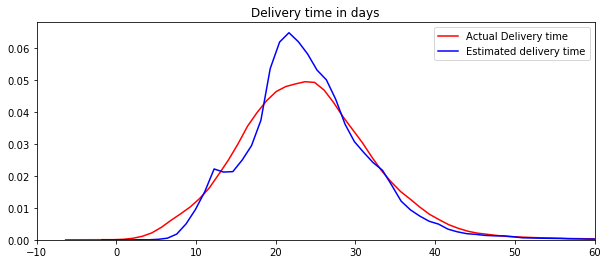

In [9]:
# Comparing the actual delivery time against the estimated delivery time

# Converting all the dates to pandas datetime format
order_reviews['order_approved_at'] = pd.to_datetime(order_reviews['order_approved_at'])
order_reviews['order_estimated_delivery_date'] = pd.to_datetime(order_reviews['order_estimated_delivery_date'])
order_reviews['order_delivered_customer_date'] = pd.to_datetime(order_reviews['order_delivered_customer_date'])

# Calculate actual delivery time from customer buying the product to receiveing the product
order_reviews['actual_delivery_time'] = (order_reviews['order_delivered_customer_date'] - order_reviews['order_approved_at']).dt.total_seconds() / 86400

# Calculating the estimated delivery time
order_reviews['estimated_delivery_time'] = (order_reviews['order_estimated_delivery_date'] - order_reviews['order_approved_at']).dt.total_seconds() / 86400

# Comparing the actual delivery time and estimated delivery time
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")

ax1 = sns.kdeplot(order_reviews['actual_delivery_time'].dropna(), color="red", label='Actual Delivery time')
ax2 = sns.kdeplot(order_reviews['estimated_delivery_time'].dropna(), color="blue", label='Estimated delivery time')

plt.xlim(-10, 60)

### Comparing the means between **'actual_delivery_time'** and **'estimated_delivery_time'**

In [10]:
# Testing for a significant difference between the estimated delivery time and actual delivery time
sample1 = np.array(order_reviews['actual_delivery_time'].dropna())
sample2 = np.array(order_reviews['estimated_delivery_time'].dropna())

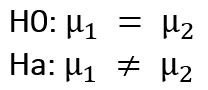

In [11]:
Image('Hypothesis_comparing_means.png')

### Testing matched samples t tests

In [12]:
# Matched sample test
t_statistic, p_value = ttest_rel(sample1, sample2)

In [13]:
α = 0.05

# Checking p value against α
if p_value < α:
    print('P value = ', p_value)
    print('Reject H0')
    print('There is a significant difference between the estimated delivery time and actual delivery time')
else:
    print('P value = ', p_value)
    print('Cannot Reject H0')

P value =  1.1313533589878193e-09
Reject H0
There is a significant difference between the estimated delivery time and actual delivery time


In [14]:
# Frequency of reviews given by customers
order_reviews.review_title.value_counts()

Late Delivery             3985
Great Customer Service    3170
Great product             3035
Bad Quality               2996
Wrong Product             2975
Product was broken        2964
Bad Customer Service      2946
Not User Friendly         2841
Name: review_title, dtype: int64

In [15]:
# Weekly Analysis of the reviews

# Week number when the customer recieved the delivery
order_reviews['delivery_week'] = order_reviews['order_delivered_customer_date'].dt.week.astype(str)

# Year number when the customer recieved the delivery
order_reviews['delivery_year'] = order_reviews['order_delivered_customer_date'].dt.year.astype(str)

# Creating a unique identifier for the week and the year of the date when the order was delivered
order_reviews['delivery_year_week'] = order_reviews['delivery_year'] + order_reviews['delivery_week']

In [16]:
pd.set_option('display.max_rows', order_reviews.shape[0]+1)

In [17]:
# Most common review on a weekly basis
order_reviews.groupby(['delivery_year_week'])['review_title'].apply(lambda x:x.value_counts().index[0])

delivery_year_week
201710             Late Delivery
201711             Late Delivery
201712      Bad Customer Service
201713             Late Delivery
201714               Bad Quality
201715             Late Delivery
201716             Late Delivery
201717             Late Delivery
201718             Great product
201719        Product was broken
201720             Late Delivery
201721      Bad Customer Service
201722             Late Delivery
201723             Late Delivery
201724             Late Delivery
201725             Great product
201726               Bad Quality
201727             Late Delivery
201728             Late Delivery
201729             Late Delivery
201730        Product was broken
201731             Late Delivery
201732    Great Customer Service
201733             Late Delivery
201734             Late Delivery
201735             Late Delivery
201736             Late Delivery
201737    Great Customer Service
201738             Late Delivery
201739             Late 

In [18]:
# Using this function, you can adjust the number of rows you want to be displayed while printing the dataframe
pd.set_option('display.max_rows', 10)

### Testing proportion of Late Delivery reviews

In [19]:
# Count of Late Delivery orders per week
num_late_delivery_weekly = order_reviews.groupby(order_reviews.delivery_year_week).review_title.apply(lambda x: (x=='Late Delivery').sum())

In [20]:
# Count of orders per week
num_orders_weekly = order_reviews.groupby(order_reviews.delivery_year_week).order_id.count()

In [21]:
proportion_late_deliveries = num_late_delivery_weekly/ num_orders_weekly

### 2) Conduct a hypothesis test to compare the organization late delivery % with the industry average which is 6%

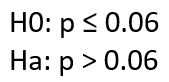

In [22]:
Image('Hypothesis_Testing_proportion_.png')

In [23]:
successes = np.sum(num_late_delivery_weekly)
sample_size = np.sum(num_orders_weekly)

In [24]:
z_statistic, p_value = proportions_ztest(successes, sample_size, value = 0.06, alternative = 'larger')

#### **Note:** <br>

**Ha: p < 0.06 (1 tailed test)**<br>
alternative = 'smaller'

**Ha: p > 0.06 (1 tailed test)**<br>
alternative = 'larger'

**Ha: p != 0.06 (2 tailed test)**<br>
alternative = 'two-sided'

In [25]:
p_value

5.179425725521796e-08

In [26]:
α = 0.05

# Checking p value against α
if p_value < α:
    print('P value = ', p_value)
    print('Reject H0')
    print('The proportion of Late Delivery complaints is > 0.06')
else:
    print('P value = ', p_value)
    print('Cannot Reject H0')
    print('The proportion of Late Delivery complaints is <= 0.06')

P value =  5.179425725521796e-08
Reject H0
The proportion of Late Delivery complaints is > 0.06


### 3) A/B Testing

#### Compare late delivery complaint % before and after the algorithm was rolled out.

In [27]:
ab_testing_orders = pd.read_csv('ab_testing_orders.csv')
ab_testing_reviews = pd.read_csv('ab_testing_reviews.csv')

In [28]:
# Merging the orders dataset with the reviews dataset
ab_testing_orders_reviews = pd.merge(ab_testing_orders, ab_testing_reviews, how='left', left_on='order_id', right_on= 'order_id')

In [29]:
# Number of customers in the Treatment group and Control group
ab_testing_orders_reviews.group.value_counts()

Treatment    18235
Control      15000
Name: group, dtype: int64

In [30]:
# Creating a new column, Delivery_Complaint
# Delivery_Complaint = True if review_title = Late Delivery, else False
ab_testing_orders_reviews['Delivery_Complaint'] = ab_testing_orders_reviews['review_title'].apply(lambda x: x == 'Late Delivery')

In [31]:
# 'True' is the number of orders in the dataset having delivery complaints
# 'False' is the number of orders in the dataset not having a delivery complaint
ab_testing_orders_reviews['Delivery_Complaint'].value_counts()

False    31267
True      1968
Name: Delivery_Complaint, dtype: int64

In [32]:
# Number of Delivery complains in the Control and Treatment Groups
successes = ab_testing_orders_reviews.groupby('group')['Delivery_Complaint'].sum()

In [33]:
successes

group
Control      1013.0
Treatment     955.0
Name: Delivery_Complaint, dtype: float64

In [34]:
# Sample Size taken for the Control and Treatment Groups
# This counts the number of True values in the Control and Treatment groups. Remember, True means review_title = Late Delivery
sample_size = ab_testing_orders_reviews.groupby('group')['order_id'].count()

In [35]:
proportions = successes/ sample_size

### With Library

### **Hypothesis**

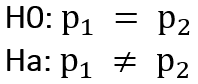

In [36]:
Image('proportions_test.png')

In [37]:
z_statistic, p_value = proportions_ztest(successes, sample_size, alternative = 'two-sided')

In [38]:
print('z_statistic = ', z_statistic)
print('p_value = ', p_value)

z_statistic =  5.827515932146575
p_value =  5.6258480616739625e-09


Depending on the level of significance (α), I can decide to accept or reject the alternate hypothesis

If α = 0.05

I reject H0, since: p value < α <br>
     &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;            5.62585e-09 < 0.05
                    
**Conclusion:**<br>
There is a significant difference between the two samples

### Without library

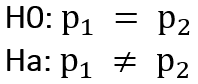

In [39]:
Image('proportions_test.png')

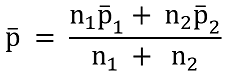

In [40]:
Image('p_.png')

In [41]:
p = sum(successes)/sum(sample_size)

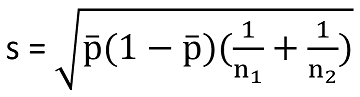

In [42]:
Image('sample_std_.png')

In [43]:
sp = np.sqrt(p*(1-p)*sum(1/sample_size))

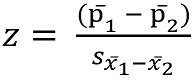

In [44]:
Image('z_statistic_.png')

In [45]:
p1 = proportions[0]
p2 = proportions[1]

In [46]:
z = (p1 - p2)/sp

In [47]:
p_value = 2*(1 - sc.norm.cdf(z))

In [48]:
α = 0.05

In [49]:
z_alpha = sc.norm.ppf(α/2)

In [50]:
# Reject H0 if z score <= z_alpha or z score >= z_alpha

if z<= z_alpha or z>= -z_alpha:
    print('Reject H0')
    print('The proportions are not equal')

else:
    print('Cannot Reject H0')

Reject H0
The proportions are not equal


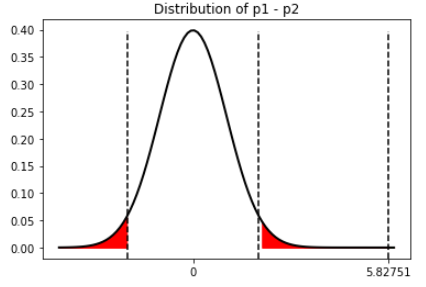

In [51]:
Image('Distribution_p1p2.png')

#### Comparing the actual delivery time against the estimated delivery time for the treatment dataset

In [52]:
order_reviews_treatment_group = ab_testing_orders_reviews[ab_testing_orders_reviews['group'] == 'Treatment']

c:\users\prateek.dasgupta\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\prateek.dasgupta\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\prateek.dasgupta\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWa

(-10, 60)

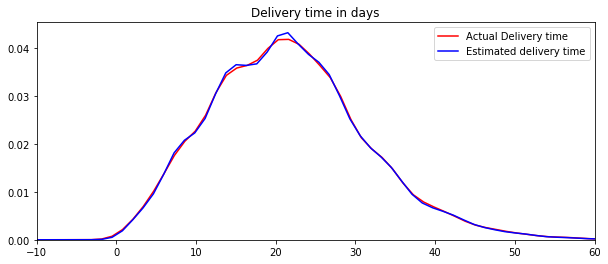

In [53]:
# Converting all the dates to pandas datetime format
order_reviews_treatment_group['order_approved_at'] = pd.to_datetime(order_reviews_treatment_group['order_approved_at'])
order_reviews_treatment_group['order_estimated_delivery_date'] = pd.to_datetime(order_reviews_treatment_group['order_estimated_delivery_date'])
order_reviews_treatment_group['order_delivered_customer_date'] = pd.to_datetime(order_reviews_treatment_group['order_delivered_customer_date'])

# Calculate actual delivery time from customer buying the product to receiveing the product
order_reviews_treatment_group['actual_delivery_time'] = (order_reviews_treatment_group['order_delivered_customer_date'] - order_reviews_treatment_group['order_approved_at']).dt.total_seconds() / 86400

# Calculating the estimated delivery time
order_reviews_treatment_group['estimated_delivery_time'] = (order_reviews_treatment_group['order_estimated_delivery_date'] - order_reviews_treatment_group['order_approved_at']).dt.total_seconds() / 86400

# Comparing the actual delivery time and estimated delivery time
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")

ax1 = sns.kdeplot(order_reviews_treatment_group['actual_delivery_time'].dropna(), color="red", label='Actual Delivery time')
ax2 = sns.kdeplot(order_reviews_treatment_group['estimated_delivery_time'].dropna(), color="blue", label='Estimated delivery time')

plt.xlim(-10, 60)

In [54]:
order_reviews_treatment_group['estimated_delivery_time']

0        99.102951
3        91.046262
5        92.478322
7        68.161111
10       65.975278
           ...    
33222    13.864167
33223     4.864132
33224     4.645590
33231     4.475498
33232     5.395058
Name: estimated_delivery_time, Length: 18235, dtype: float64

In [55]:
# Testing for a significant difference between the estimated delivery time and actual delivery time
sample_estimated_delivery_time = np.array(order_reviews_treatment_group['actual_delivery_time'])
sample_actual_delivery_time = np.array(order_reviews_treatment_group['estimated_delivery_time'])

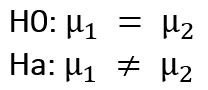

In [56]:
Image('Hypothesis_comparing_means.png')

In [57]:
# Matched sample test
t_statistic, p_value = ttest_rel(sample_estimated_delivery_time, sample_actual_delivery_time)

In [58]:
α = 0.05

# Checking p value against α
if p_value < α:
    print('P value = ', p_value)
    print('Reject H0')
    print('Populations means are not equal')
else:
    print('P value = ', p_value)
    print('Cannot Reject H0')

P value =  0.21684841987770798
Cannot Reject H0
Populations means are equal
